In [1]:
import torch
import torchaudio
import torchaudio.functional as tf

import copy
import matplotlib.pyplot as plt
from IPython.display import Audio as PyAudio, display
import numpy as np

# Audio utils

In [2]:
class AudioWorker:
    def __init__(self, path, name=None):

        self.name = name
        self.path = path

        self.__unloaded__ = "unloaded"
        self.loaded = False
        self.wave = None
        self.rate = None

    def load(self):
        self.wave, self.rate = torchaudio.load(self.path)
        self.loaded = self.wave.size(1) > 0
        return self

    def resample(self, to_freq):
        if self.rate == to_freq:
            return

        self.wave = tf.resample(self.wave, self.rate, to_freq)
        self.rate = to_freq

    def player(self, mask=None):
        if not self.loaded:
            return self.__unloaded__
        if mask is None:
            return display(PyAudio(self.wave, rate=self.rate, autoplay=False))
        else:
            return display(PyAudio(self.wave[:, mask], rate=self.rate, autoplay=False))

    def plot_waveform(self, mask=None, regions=None, win_length=None, hop_length=None, region_linewidth=None):
        if not self.loaded:
            return self.__unloaded__
        waveform = self.wave.numpy()

        num_channels, num_frames = waveform.shape
        time = torch.arange(0, num_frames) / self.rate

        figure, axes = plt.subplots(num_channels, 1)
        if num_channels == 1:
            axes = [axes]

        for c in range(num_channels):
            values = waveform[c]

            if mask is not None:
                axes[c].plot(time[~mask], values[~mask], "o", linewidth=1, c="red")

            axes[c].plot(time, values, linewidth=1, c="green")

            if not (None in [regions, win_length, hop_length, region_linewidth]):
                max_val = values.max()
                for i, label in enumerate(regions):
                    s = i * hop_length
                    e = s + win_length
                    plot_values = [max_val / ((label == 1) + 1)] * hop_length
                    plot_color = "green" if (label == 1) else "red"
                    axes[c].plot(time[s:e], plot_values, c=plot_color, linewidth=region_linewidth)

            axes[c].grid(True)
            if num_channels > 1:
                axes[c].set_ylabel(f"Channel {c + 1}")
        figure.suptitle(f"Waveform of {self.name}")

    def deepcopy(self):
        return copy.deepcopy(self)

In [3]:
def calculate_rms(tensor):
    return torch.sqrt(torch.mean(tensor ** 2))


def add_noise(audio, noise, snr_db, start, end, in_seconds=True, sample_rate=8000):
    if start < 0:
        start = 0
    if end is not None:
        if end < 0:
            end = start - end
    if in_seconds:
        start = int(start * sample_rate)
        if start >= audio.size(-1):
            return audio
        if end is None:
            end = audio.size(-1)
        else:
            end = min(audio.size(-1), int(end * sample_rate))
    if end is None:
        end = audio.size(-1)
    audio_part = audio[:, start:end]
    orig_noise = noise.clone()
    if torch.sum(torch.isnan(orig_noise)):
        print("orig noise has nan")
    while end - start > noise.size(-1):
        noise = torch.cat([noise, orig_noise], dim=1)
    noise = noise[:, : end - start]
    if torch.sum(torch.isnan(noise)):
        print("nan after repeating nosie ", torch.sum(torch.isnan(orig_noise)), torch.sum(torch.isnan(noise)))
    #     noised = tf.add_noise(audio_part, noise, torch.Tensor([snr_db]))

    signal_rms = calculate_rms(audio_part)

    # Calculate RMS of the noise
    noise_rms = calculate_rms(noise)

    # Calculate desired noise RMS based on SNR
    snr = 10 ** (snr_db / 20)
    desired_noise_rms = signal_rms / snr

    # Scale noise to match the desired RMS
    scaled_noise = noise * (desired_noise_rms / (noise_rms + 1e-10))  # Adding small value to avoid division by zero

    # Add the scaled noise to the original signal
    noised = audio_part + scaled_noise

    # Debugging: Check for NaNs or Infs
    if torch.isnan(noised).any() or torch.isinf(noised).any():
        print("Noisy waveform contains NaNs or Infs")

    if torch.sum(torch.isnan(noised)):
        print("nan after applying noise ",
              audio[:, start:end].size(),
              noise.size(),
              torch.Tensor([snr_db]),
              torch.sum(torch.isnan(noised)))
    temp = audio.clone()
    temp[:, start:end] = noised
    if torch.sum(torch.isnan(temp)):
        print("nan after chnaging temp slice ", torch.sum(torch.isnan(temp)))
    return temp


def augment_sample(aw, noises=None, noise_count=1, noise_duration_range=(2, 5), snr_db=3):
    audio = aw.wave
    sample_rate = aw.rate
    orig_audio = audio.clone()
    augmentation_params = None

    if noises is None:
        return orig_audio, augmentation_params
        
    resampled_noises = []
    for noise in noises:
        if noise.rate != sample_rate:
            temp = noise.deepcopy()
            temp.resample(sample_rate)
            resampled_noises.append(temp.wave)
        else:
            resampled_noises.append(noise.wave)
    noises = resampled_noises

    sec = audio.size(-1) / sample_rate
    

    if noise_count <= 0:
        return orig_audio, augmentation_params

    noises_starts, _ = torch.sort(torch.rand(noise_count) * sec)
    noise_durations = torch.rand(noise_count) * (noise_duration_range[1] - noise_duration_range[0]) + \
                      noise_duration_range[0]

    noises_to_use = torch.randint(len(noises), (noise_count,))

    for i, noise_ind in enumerate(noises_to_use):
        orig_audio = add_noise(orig_audio,
                         noises[noise_ind],
                         snr_db=snr_db,
                         start=noises_starts[i],
                         end=-noise_durations[i],
                         sample_rate=sample_rate)

    augmentation_params = {"noises_starts": noises_starts,
                           "noise_durations": noise_durations,
                           "noises_to_use": noises_to_use}
                           
    return orig_audio, augmentation_params

# Loading data

In [4]:
from torch.utils.data import Dataset
import os, glob

In [5]:
class OpenSLRDataset(Dataset):
    @staticmethod
    def get_files_by_extension(directory, ext='txt'):
        pattern = os.path.join(directory, '**', f'*.{ext}')
        return [os.path.relpath(path, directory) for path in glob.glob(pattern, recursive=True)]

    @staticmethod
    def change_file_extension(file_path, new_extension):
        ext = new_extension.strip('.')
        return os.path.splitext(file_path)[0] + "." + ext

    def __init__(self, openslr_path, labels_pack_path, blacklist=[]):
        self.openslr_path = openslr_path
        self.labels_pack_path = labels_pack_path
        self.blacklist = blacklist

        self.txt_files = [p for p in self.get_files_by_extension(self.labels_pack_path)
                          if os.path.splitext(os.path.basename(p))[0] not in self.blacklist]

        args = os.path.basename(self.labels_pack_path).split("_")
        self.sample_rate = int(args[0])
        self.vad_window = int(args[1])
        self.vad_overlap_percent = int(args[2]) / 100.0
        self.label_region_sec = int(args[3]) / 1000.0
        self.label_overlap_percent = int(args[4]) / 100.0
        self.decision_function_name = args[5]
        self.label_window = self.sample_rate * self.label_region_sec
        self.label_hop = self.label_window * (1 - self.label_overlap_percent)

    def __len__(self):
        return len(self.txt_files)

    def __getitem__(self, idx) -> AudioWorker:
        file_path = os.path.join(self.labels_pack_path, self.txt_files[idx])
        with open(file_path, 'r') as file:
            labels_text = file.readline().strip()

        audio_file_path = self.change_file_extension(self.txt_files[idx], ".flac")
        name = os.path.splitext(audio_file_path)[0].replace("\\", "-")
        au = AudioWorker(os.path.join(self.openslr_path, audio_file_path), name)
        au.load()

        return au, labels_text

In [6]:
noise_data_path = "/kaggle/input/environmental-sound-classification-50/audio/audio/16000"
clean_audios_path = "/kaggle/input/librispeech-100-normalized/LibriSpeech/train-clean-100"
clean_labels_path = "/kaggle/input/librispeech-webrtcvad-speech-labels/8000_30_50_100_50_max"

blacklist = ['7067-76048-0021']

dataset = OpenSLRDataset(clean_audios_path, clean_labels_path, blacklist)
noise_files_paths = [os.path.join(noise_data_path, p) for p in os.listdir(noise_data_path) if p.endswith(".wav")]
print(f"Found {len(dataset)} clear audio files")
print(f"Found {len(noise_files_paths)} noise audio files")

Found 28538 clear audio files
Found 2000 noise audio files


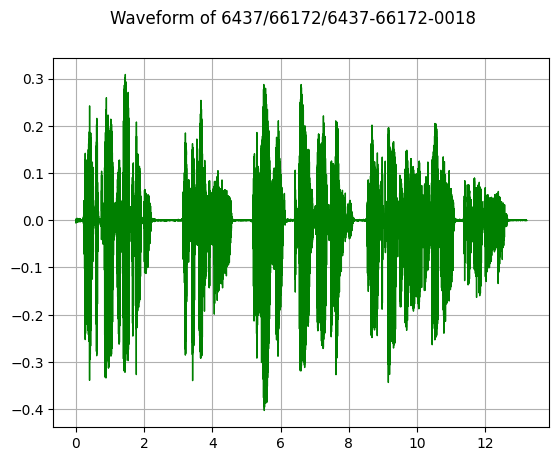

In [7]:
au, label = dataset[1000]
au.player()
au.plot_waveform()

# Model

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import os
import random
from tqdm import tqdm
from time import time

In [9]:
class WaveToMFCCConverter:
    def __init__(self, n_mfcc, sample_rate=8000, frame_duration_in_ms=None, win_length=None, hop_length=None):
        self.n_mfcc = n_mfcc

        if frame_duration_in_ms is not None:
            sample_count = torch.tensor(sample_rate * frame_duration_in_ms / 1000, dtype=torch.int)
            win_length = torch.pow(2, torch.ceil(torch.log2(sample_count)).to(torch.int)).to(torch.int).item()
        elif win_length is None:
            return
        win_length = int(win_length)

        if hop_length is None:
            hop_length = int(win_length // 2)
        hop_length = int(hop_length)

        mfcc_params = {
            "n_mfcc": n_mfcc,
            "sample_rate": sample_rate
        }
        mel_params = {
            "n_fft": win_length,
            "win_length": win_length,
            "hop_length": hop_length,
            "center": False
        }

        self.converter = torchaudio.transforms.MFCC(**mfcc_params, melkwargs=mel_params)

    def __call__(self, waveform):
        return self.converter(waveform).transpose(-1, -2)

In [10]:
class NoiseCollate:
    def __init__(self, dataset_sample_rate, noises, params, mfcc_converter):
        self.dataset_sample_rate = dataset_sample_rate
        self.noises = noises
        self.params = params
        self.mfcc_converter = mfcc_converter
        
    def __call__(self, batch):
        inputs = []
        targets = []

        for au, label_txt in batch:
            au.resample(self.dataset_sample_rate)
            if self.params is None:
                augmented_wave, _ = augment_sample(au, self.noises)
            else:
                augmented_wave, _ = augment_sample(au, self.noises, **self.params)
            inp = self.mfcc_converter(augmented_wave)
            tar = torch.tensor([*map(float, label_txt)])
            if tar.size(-1) != inp.size(-2):
                print(tar.size(-1), inp.size(-2), au.name)
            inputs.append(inp)
            targets.append(tar)

        inp_dim_2 = max(i.size(1) for i in inputs)
        inputs_tens = torch.zeros([len(inputs), inp_dim_2, inputs[0].size(-1)])
        for i, inp in enumerate(inputs):
            inputs_tens[i, :inp.size(1), :] = inp

        tar_dim_1 = max(t.size(0) for t in targets)
        targets_tens = torch.zeros([len(targets), tar_dim_1, 1])
        for i, tar in enumerate(targets):
            targets_tens[i, :tar.size(0), 0] = tar

        return inputs_tens, targets_tens

In [33]:
def get_validation_score(model, loss_function, threshold, dataloader, device):
    loss = 0
    correct_count = 0
    whole_count = 0
    for batch_inputs, batch_targets in dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        output = model(batch_inputs)
        loss += loss_function(output, batch_targets)
        
        correct_count += torch.sum((output > threshold) == (batch_targets > threshold))
        whole_count += batch_targets.numel()
    loss /= whole_count
    accuracy = correct_count / whole_count
    
    return loss, accuracy

In [34]:
class SimpleG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(SimpleG, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
train_ratio = 0.9
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=2**7, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=2**7, shuffle=True, num_workers=4)

In [37]:
input_size = 64
hidden_dim = 48

model = SimpleG(input_dim=input_size, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
bce = torch.nn.BCEWithLogitsLoss()
bce_without_averaging = torch.nn.BCEWithLogitsLoss(reduction="sum")
loss_history = []

In [39]:
do_epoches = 1
epoch_noise_count = 500
train_snr = 3
params = {
    "noise_count": 2,
    "noise_duration_range": (5, 10),
    "snr_db": train_snr
}
val_params = params.copy()
threshold = 0.7

mfcc_converter = WaveToMFCCConverter(
    n_mfcc=input_size,
    sample_rate=dataset.sample_rate,
    win_length=dataset.label_window,
    hop_length=dataset.label_hop)

train_dataloader.collate_fn = NoiseCollate(dataset.sample_rate, None, params, mfcc_converter)
val_dataloader.collate_fn = NoiseCollate(dataset.sample_rate, None, val_params, mfcc_converter)

check_validation_every = 12

model.train()
for epoch in range(do_epoches):
    noises = [AudioWorker(p, p.replace("\\", "__")) for p in random.sample(noise_files_paths, epoch_noise_count)]
    for noise in noises:
        noise.load()
        noise.resample(dataset.sample_rate)

    train_dataloader.collate_fn.noises = noises
    
    n = 0
    running_loss = 0
    running_correct_count = 0
    running_whole_count = 0
    
    for batch_inputs, batch_targets in tqdm(train_dataloader, desc=f"epoch {epoch + 1}", disable=1):
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        output = model(batch_inputs)

        loss = bce(output, batch_targets)
        loss_history.append(loss.item())
        running_loss += loss.item() * batch_targets.numel()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_correct_count += torch.sum((output > threshold) == (batch_targets > threshold))
        running_whole_count += batch_targets.numel()
        
        
        if n % check_validation_every == check_validation_every - 1:
            model.eval()
            batch_accuracy = running_correct_count/running_whole_count
            running_loss /= running_whole_count
            print(f"{'='*40}")
            print(f"Train")
            print(f"{'-'*30}")
            print(f"Batch\nLoss: {loss}\nAccuracy: {batch_accuracy}")
            print(f"{'-'*30}\n")
            s = time()
            val_dataloader.collate_fn.noises = None
            val_loss, val_acc = get_validation_score(model, bce_without_averaging, threshold, val_dataloader, device)
            print(f"Validation")
            print(f"{'-'*30}")
            print(f"Clear audis\nLoss: {val_loss}\nAccuracy: {val_acc}")
            print(f"{'-'*30}")
            val_dataloader.collate_fn.noises = noises
            val_dataloader.collate_fn.params["snr_db"] = 0
            val_loss, val_acc = get_validation_score(model, bce_without_averaging, threshold, val_dataloader, device)
            print(f"Noised audis snrDB 0\nLoss: {val_loss}\nAccuracy: {val_acc}")
            print(f"{'-'*30}")
            val_dataloader.collate_fn.params["snr_db"] = 5
            val_loss, val_acc = get_validation_score(model, bce_without_averaging, threshold, val_dataloader, device)
            print(f"Noised audis snrDB 5\nLoss: {val_loss}\nAccuracy: {val_acc}")
            print(f"{'-'*30}")
            val_dataloader.collate_fn.params["snr_db"] = 10
            val_loss, val_acc = get_validation_score(model, bce_without_averaging, threshold, val_dataloader, device)
            print(f"Noised audis snrDB 10\nLoss: {val_loss}\nAccuracy: {val_acc}")
            print(f"{'-'*30}")
            print("Validation loss calulated in ", time() - s, "seconds")
            print(f"{'='*40}\n")
            
            running_loss = 0
            running_correct_count = 0
            running_whole_count = 0
            model.train()
        
        n+=1

model.eval()

Train
------------------------------
Batch
Loss: 0.544109046459198
Accuracy: 0.46110811829566956
------------------------------

Validation
------------------------------
Clear audis
Loss: 0.5067766904830933
Accuracy: 0.7294619679450989
------------------------------
Noised audis snrDB 0
Loss: 0.5502999424934387
Accuracy: 0.6223974823951721
------------------------------
Noised audis snrDB 5
Loss: 0.5284019708633423
Accuracy: 0.6682981252670288
------------------------------
Noised audis snrDB 10
Loss: 0.5157709717750549
Accuracy: 0.6995048522949219
------------------------------
Validation loss calulated in  68.68268394470215 seconds

Train
------------------------------
Batch
Loss: 0.44823044538497925
Accuracy: 0.752805233001709
------------------------------

Validation
------------------------------
Clear audis
Loss: 0.42563381791114807
Accuracy: 0.876198947429657
------------------------------


KeyboardInterrupt: 

In [ ]:
loss_history